# 12. NLP를 위한 합성곱 신경망(Convolution Neural Network)

## 6) 사전 훈련된 워드 임베딩을 이용한 의도 분류(Intent Classification using Pre-trained Word Embedding)

의도 분류(Intent Classification)는 개체명 인식(Named Entity Recognition)과 더불어 챗봇(Chatbot)의 중요 모듈로서 사용될 수 있습니다. 

사전 훈련된 워드 임베딩(Pre-traiend word embedding)을 입력으로 의도 분류를 수행해봅시다. 

의도 분류 실습은 결국 텍스트 분류입니다.

### 1. 데이터 로드와 전처리

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [2]:
train_data = pd.read_csv('datasets/intent_train_data.csv')
test_data = pd.read_csv('datasets/intent_test_data.csv')

In [4]:
train_data

,intent,label
0,add another song to the cita rom ntica playlist,AddToPlaylist
1,add clem burke in my playlist pre party r b jams,AddToPlaylist
2,add live from aragon ballroom to trapeo,AddToPlaylist
3,add unite and win to my night out,AddToPlaylist
4,add track to my digster future hits,AddToPlaylist
...,...,...
11779,can a i get the movie schedule for sympathy fo...,SearchScreeningEvent
11780,find movie schedules for animated movies aroun...,SearchScreeningEvent
11781,what time is bordertown trail showing,SearchScreeningEvent
11782,in the neighbourhood find movies with movie times,SearchScreeningEvent


In [5]:
intent_train = train_data['intent'].tolist()
label_train = train_data['label'].tolist()
intent_test = test_data['intent'].tolist()
label_test = test_data['label'].tolist()

print('훈련용 문장의 수 :', len(intent_train))
print('훈련용 레이블의 수 :', len(label_train))
print('테스트용 문장의 수 :', len(intent_test))
print('테스트용 레이블의 수 :', len(label_test))

훈련용 문장의 수 : 11784
훈련용 레이블의 수 : 11784
테스트용 문장의 수 : 600
테스트용 레이블의 수 : 600


In [6]:
print(intent_train[:5])
print(label_train[:5])

['add another song to the cita rom ntica playlist', 'add clem burke in my playlist pre party r b jams', 'add live from aragon ballroom to trapeo', 'add unite and win to my night out', 'add track to my digster future hits']
['AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist']


In [11]:
for i in range(2000, 10002, 2000):
    print(intent_train[i:i+2])
    print(label_train[i:i+2])
    print()

['please book reservations for 3 people at a restaurant in alderwood manor', 'book a table in mt for 3 for now at a pub that serves south indian']
['BookRestaurant', 'BookRestaurant']

['what will the weather be like on feb 8 , 2034 in cedar mountain wilderness', "tell me the forecast in the same area here on robert e lee 's birthday"]
['GetWeather', 'GetWeather']

['rate the current album one points', 'i give a zero rating for this essay']
['RateBook', 'RateBook']

["i'm trying to find the show chant ii", 'find spirit of the bush']
['SearchCreativeWork', 'SearchCreativeWork']

['when is blood and ice cream trilogie playing at the nearest movie theatre \\?', 'show movie schedules']
['SearchScreeningEvent', 'SearchScreeningEvent']



데이터가 순서대로 정렬되어 있다.

<AxesSubplot:>

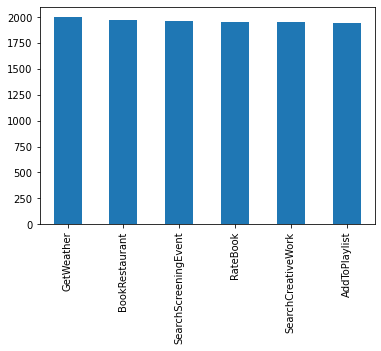

In [12]:
train_data['label'].value_counts().plot(kind='bar')

label_train과 label_test에 존재하는 6개의 카테고리들을 고유한 정수로 인코딩해봅시다.

이런 경우에는 사이킷런(sklearn)의 preprocessing.LabelEncoder()가 유용합니다.

In [13]:
# 레이블 인코딩. 레이블에 고유한 정수를 부여
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(label_train)

label_train = idx_encode.transform(label_train) # 주어진 고유한 정수로 변환
label_test = idx_encode.transform(label_test) # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print('레이블과 정수의 맵핑 관계 :',label_idx)

레이블과 정수의 맵핑 관계 : {'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


In [16]:
for i in range(0, 10002, 2000):
    print(intent_train[i:i+2])
    print(label_train[i:i+2])
    print()

['add another song to the cita rom ntica playlist', 'add clem burke in my playlist pre party r b jams']
[0 0]

['please book reservations for 3 people at a restaurant in alderwood manor', 'book a table in mt for 3 for now at a pub that serves south indian']
[1 1]

['what will the weather be like on feb 8 , 2034 in cedar mountain wilderness', "tell me the forecast in the same area here on robert e lee 's birthday"]
[2 2]

['rate the current album one points', 'i give a zero rating for this essay']
[3 3]

["i'm trying to find the show chant ii", 'find spirit of the bush']
[4 4]

['when is blood and ice cream trilogie playing at the nearest movie theatre \\?', 'show movie schedules']
[5 5]



In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)

sequences = tokenizer.texts_to_sequences(intent_train)
sequences[:5] # 상위 5개 샘플 출력

[[11, 191, 61, 4, 1, 4013, 1141, 1572, 15],
 [11, 2624, 1573, 3, 14, 15, 939, 82, 256, 188, 548],
 [11, 187, 42, 2625, 4014, 4, 1968],
 [11, 2626, 22, 2627, 4, 14, 192, 27],
 [11, 92, 4, 14, 651, 520, 195]]

In [18]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :', vocab_size)

단어 집합(Vocabulary)의 크기 : 9870


문장의 최대 길이 : 35
문장의 평균 길이 : 9.364392396469789


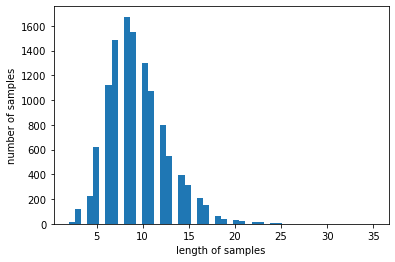

In [19]:
print('문장의 최대 길이 :',max(len(l) for l in sequences))
print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))

plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
# 최대 길이 35로 모든 훈련 데이터를 패딩하겠습니다.
max_len = 35

intent_train = pad_sequences(sequences, maxlen = max_len)
label_train = to_categorical(np.asarray(label_train))
print('훈련 데이터의 크기(shape):', intent_train.shape)
print('훈련 데이터 레이블의 크기(shape):', label_train.shape)

훈련 데이터의 크기(shape): (11784, 35)
훈련 데이터 레이블의 크기(shape): (11784, 6)


In [21]:
print('훈련 데이터의 첫번째 샘플 :',intent_train[0])
print('훈련 데이터의 첫번째 샘플의 레이블 :',label_train[0])

훈련 데이터의 첫번째 샘플 : [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   11  191
   61    4    1 4013 1141 1572   15]
훈련 데이터의 첫번째 샘플의 레이블 : [1. 0. 0. 0. 0. 0.]


앞서 언급했듯이 훈련 데이터가 일정한 순서로 배치되어져 있으므로 순서를 랜덤으로 섞어주겠습니다.

In [22]:
indices = np.arange(intent_train.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :', indices)

랜덤 시퀀스 : [ 9100 11276   698 ...  4095  8046   172]


In [23]:
intent_train = intent_train[indices]
label_train = label_train[indices]

In [24]:
# 검증 데이터는 훈련 데이터 중 10%만을 사용합니다. 
n_of_val = int(0.1 * intent_train.shape[0])
print('검증 데이터의 개수 :',n_of_val)

검증 데이터의 개수 : 1178


In [47]:
X_train = intent_train[:-n_of_val]
y_train = label_train[:-n_of_val]

X_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]

X_test = intent_test
y_test = label_test

In [26]:
print('훈련 데이터의 크기(shape):', X_train.shape)
print('검증 데이터의 크기(shape):', X_val.shape)
print('훈련 데이터 레이블의 크기(shape):', y_train.shape)
print('검증 데이터 레이블의 크기(shape):', y_val.shape)
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 데이터 레이블의 개수 :', len(y_test))

훈련 데이터의 크기(shape): (10606, 35)
검증 데이터의 크기(shape): (1178, 35)
훈련 데이터 레이블의 크기(shape): (10606, 6)
검증 데이터 레이블의 크기(shape): (1178, 6)
테스트 데이터의 개수 : 600
테스트 데이터 레이블의 개수 : 600


### 2. 사전 훈련된 워드 임베딩 사용하기

스탠포드 대학교에서 제공하는 사전 훈련된 GloVe 임베딩을 사용합니다.

In [28]:
embedding_dict = dict()
f = open(os.path.join('preTrained/glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [30]:
print(embedding_dict['respectable'])
print("임베딩 벡터의 차원 : ", len(embedding_dict['respectable']))

[-0.049773   0.19903    0.10585    0.1391    -0.32395    0.44053
  0.3947    -0.22805   -0.25793    0.49768    0.15384   -0.08831
  0.0782    -0.8299    -0.037788   0.16772   -0.45197   -0.17085
  0.74756    0.98256    0.81872    0.28507    0.16178   -0.48626
 -0.006265  -0.92469   -0.30625   -0.067318  -0.046762  -0.76291
 -0.0025264 -0.018795   0.12882   -0.52457    0.3586     0.43119
 -0.89477   -0.057421  -0.53724    0.25587    0.55195    0.44698
 -0.24252    0.29946    0.25776   -0.8717     0.68426   -0.05688
 -0.1848    -0.59352   -0.11227   -0.57692   -0.013593   0.18488
 -0.32507   -0.90171    0.17672    0.075601   0.54896   -0.21488
 -0.54018   -0.45882   -0.79536    0.26331    0.18879   -0.16363
  0.3975     0.1099     0.1164    -0.083499   0.50159    0.35802
  0.25677    0.088546   0.42108    0.28674   -0.71285   -0.82915
  0.15297   -0.82712    0.022112   1.067     -0.31776    0.1211
 -0.069755  -0.61327    0.27308   -0.42638   -0.085084  -0.17694
 -0.0090944  0.1109     0.

In [31]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print('임베딩 테이블의 크기(shape) :',np.shape(embedding_matrix))

임베딩 테이블의 크기(shape) : (9870, 100)


훈련 데이터에 있는 단어와 사전 훈련된 워드 임베딩 벡터의 값을 맵핑하여 임베딩 테이블에 저장합니다.

In [32]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### 3. 1D CNN을 이용한 의도 분류

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate

kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []
for size in kernel_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=size,
                  padding="valid", activation="relu", strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)
model_output = Dense(len(label_idx), activation='softmax')(output)
model = Model(model_input, model_output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 100)      987000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 34, 512)      102912      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 33, 512)      154112      embedding[0][0]                  
______________________________________________________________________________________________

In [34]:
history = model.fit(X_train, y_train, batch_size=64,
                    epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
166/166 [==============================] - 5s 12ms/step - loss: 0.1959 - acc: 0.9421 - val_loss: 0.0510 - val_acc: 0.9881
Epoch 2/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0509 - acc: 0.9850 - val_loss: 0.0503 - val_acc: 0.9822
Epoch 3/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0281 - acc: 0.9923 - val_loss: 0.0343 - val_acc: 0.9907
Epoch 4/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0211 - acc: 0.9942 - val_loss: 0.0323 - val_acc: 0.9915
Epoch 5/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0171 - acc: 0.9950 - val_loss: 0.0340 - val_acc: 0.9847
Epoch 6/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0093 - acc: 0.9981 - val_loss: 0.0306 - val_acc: 0.9907
Epoch 7/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0090 - acc: 0.9976 - val_loss: 0.0280 - val_acc: 0.9898
Epoch 8/10
166/166 [==============================] - 1s 7ms/step - loss: 0

정확도와 loss의 변화를 그래프로 시각화해봅시다.

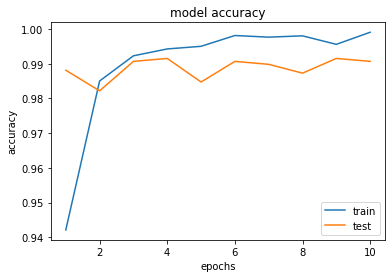

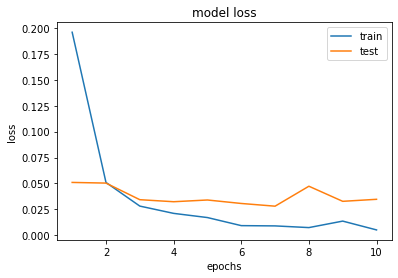

In [35]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [48]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

In [49]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 예측을 정수 시퀀스로 변환

print('정확도(Accuracy) : ', sum(y_predicted == y_test) / len(y_test))

정확도(Accuracy) :  0.9933333333333333
